# DataLab Cup 3: Reverse Image Caption

# Download Dataset from Kaggle

In [3]:
# Follow the tutorial in this page:
# https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/
!cat ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c datalab-cup3-reverse-image-caption-2021

{"username":"chengchecheng","key":"f6946452bb7b6297237d925ac6034cb7"}Downloading datalab-cup3-reverse-image-caption-2021.zip to /home/kevin/NTHU/2021 Fall/Deep-Learning-Course-Team-Project/Competition 3
100%|███████████████████████████████████████▉| 666M/667M [01:02<00:00, 11.6MB/s]
100%|████████████████████████████████████████| 667M/667M [01:02<00:00, 11.2MB/s]


In [12]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall('./')

file_path = './datalab-cup3-reverse-image-caption-2021.zip'
zip_list(file_path)

# Libraries and Packages Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable warnings, info and errors 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import re

In [2]:
!nvidia-smi

Thu Jan  6 14:02:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   44C    P8    14W / 250W |     19MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        #for gpu in gpus:
        #    tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_memory_growth(gpus[1], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Preprocseeing

## Preprocess text

In [4]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [5]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


## BERT Embedding

In [6]:
def idx2word(indices_list):
    results_list = []
    for indices in indices_list:
        string = ''
        length_of_string = 0
        for idx in indices:
            if idx == '5428':
                string = string + ''
            elif idx == '5427':
                break
            else:
                string = string + id2word_dict[idx] + ' '
        results_list.append(string.strip())
    return results_list

def remove_empty_string(string_list):
    empty_flag = False
    for string in string_list:
        if string == '':
            empty_flag = True
            break
    if empty_flag == False:
        return string_list
    else:
        new_string_list = []
        for string in string_list:
            if string != '':
                new_string_list.append(string)
        return new_string_list

In [7]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained(
    'bert-large-uncased', 
    do_lower_case=False,
    do_basic_tokenize=False
)
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
def turn_to_bert_embedding(string_list):
    try:
        bert_inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
        bert_outputs = bert_model(bert_inputs)
        caption_embedding = bert_outputs.last_hidden_state[:,0]
    except(ValueError):
        print(string_list)
    return caption_embedding.numpy().tolist()

test_string = ['this flower is white and pink in color with petals that have small veins',
               'the flower shown has a purple and white petal with white anther', 
               'the four heart shaped pink petals of this flower are striped with fuchsia and their centers are yellow and white']  
print(len(turn_to_bert_embedding(test_string)[0]))

1024


In [9]:
BERT_EMBEDDING_FILE = './dataset/bert_embedding.pkl'

### Run Once

In [71]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))
df = df.reset_index(drop=True)

df['texts'] = df['Captions'].apply(lambda x: idx2word(x))

There are 7370 image in training data


In [72]:
df.head(5)

,Captions,ImagePath,texts
0,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,[the petals of the flower are pink in color an...
1,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,[this flower has white petals and yellow pisti...
2,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,[the petals on this flower are pink with white...
3,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,[the flower has a smooth purple petal with whi...
4,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,[this white flower has bright yellow stamen wi...


In [12]:
df.loc[0,'texts']

['the petals of the flower are pink in color and have a yellow center',
 'this flower is pink and white in color with petals that are multi colored',
 'the purple petals have shades of white with white anther and filament',
 'this flower has large pink petals and a white stigma in the center',
 'this flower has petals that are pink and has a yellow stamen',
 'a flower with short and wide petals that is light purple',
 'this flower has small pink petals with a yellow center',
 'this flower has large rounded pink petals with curved edges and purple veins',
 'this flower has purple petals as well as a white stamen']

In [13]:
df['texts'] = df['texts'].apply(lambda x: remove_empty_string(x))

In [14]:
df.head(5)

,Captions,ImagePath,texts
0,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,[the petals of the flower are pink in color an...
1,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,[this flower has white petals and yellow pisti...
2,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,[the petals on this flower are pink with white...
3,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,[the flower has a smooth purple petal with whi...
4,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,[this white flower has bright yellow stamen wi...


In [15]:
def count_caption_num(string_list):
    return len(string_list)

df['caption_num'] = df['texts'].apply(lambda c: count_caption_num(c))

In [16]:
df.head(5)

,Captions,ImagePath,texts,caption_num
0,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,[the petals of the flower are pink in color an...,9
1,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,[this flower has white petals and yellow pisti...,10
2,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,[the petals on this flower are pink with white...,9
3,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,[the flower has a smooth purple petal with whi...,10
4,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,[this white flower has bright yellow stamen wi...,9


In [17]:
num_dict = {}
for num in df['caption_num'].tolist():
    if num in num_dict:
        num_dict[num]+=1
    else:
        num_dict[num]=1
num_dict

{9: 1959, 10: 4837, 8: 488, 7: 75, 6: 10, 5: 1}

In [24]:
df['embeddings'] = df['texts'].apply(lambda x : turn_to_bert_embedding(x))
len(df.loc[0,'embeddings'][0])

1024

In [25]:
df.to_pickle(BERT_EMBEDDING_FILE)

In [33]:
# No need to run this cell (run inside dataset_generator())
df_bert = pd.read_pickle(BERT_EMBEDDING_FILE)

embeddings = df_bert['embeddings'].values
embedding = []

for i in range(len(embeddings)):
    for emb in embeddings[i]:
        embedding.append(emb)
embedding = np.asarray(embedding)
embedding.shape[0]

70495

In [34]:
df_bert.head()

,Captions,ImagePath,texts,caption_num,embeddings
0,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,[the petals of the flower are pink in color an...,9,"[[-0.6344168782234192, -0.8039702773094177, 0...."
1,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,[this flower has white petals and yellow pisti...,10,"[[-0.2546939551830292, -0.029211539775133133, ..."
2,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,[the petals on this flower are pink with white...,9,"[[-0.15689069032669067, -0.4372050166130066, -..."
3,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,[the flower has a smooth purple petal with whi...,10,"[[-0.07732152938842773, -0.5917125940322876, -..."
4,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,[this white flower has bright yellow stamen wi...,9,"[[-0.3246757686138153, -0.187540203332901, -0...."


## Dataset

In [10]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [11]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


### Data Augmentation
Reference: https://mmuratarat.github.io/2019-02-28/data-augmentation-in-tensorflow

In [13]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3
MAPPING_FUNC = None

def vertical_flip(tf_img):
    return tf.image.flip_left_right(tf_img)

def horizontal_flip(tf_img):
    return tf.image.flip_up_down(tf_img)

def brightness(tf_img):
    return tf.image.random_brightness(tf_img, delta=0.4, seed=2)

def central_crop(tf_img):
    return tf.image.central_crop(tf_img, 0.8)

def noise_injection(tf_img):
    noise = tf.random.normal(shape=tf.shape(tf_img), mean=0.0, stddev=1, dtype=tf.float32)
    return tf.add(tf_img, noise)

def data_generator(caption, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    img.set_shape([None, None, 3])
    
    if MAPPING_FUNC is not None:
        img = MAPPING_FUNC(img)

    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    caption = tf.cast(caption, tf.float32)    
    return img, caption

def dataset_interface(caption, image_path):
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption))
    return dataset

def dataset_generator(filenames, batch_size):
    # load the training data into two NumPy arrays
    # df = pd.read_pickle(filenames)
    # captions = df['Captions'].values
    # caption = []
    # # each image has 1 to 10 corresponding captions
    # # we choose one of them randomly for training
    # for i in range(len(captions)):
    #     caption.append(random.choice(captions[i]))
    # caption = np.asarray(caption)
    # caption = caption.astype(np.int64)
    # image_path = df['ImagePath'].values

    #------------------------------------------
    df_bert = pd.read_pickle(filenames)

    embeddings = df_bert['embeddings'].values
    imagePaths = df_bert['ImagePath'].values
    embedding = []
    image_path = []

    for i in range(len(embeddings)):
        for j in range(len(embeddings[i])):
            embedding.append(embeddings[i][j])
            image_path.append(imagePaths[i])
    embedding = np.asarray(embedding)
    embedding = embedding.astype(np.float32)
    caption = embedding
    image_path = np.asarray(image_path)
    #------------------------------------------    
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    original_dataset = dataset_interface(caption, image_path)
    dataset = original_dataset #----------------

    # MAPPING_FUNC = vertical_flip
    # vertical_dataset = dataset_interface(caption, image_path)

    # MAPPING_FUNC = horizontal_flip
    # horizontal_dataset = dataset_interface(caption, image_path)

    # MAPPING_FUNC = brightness
    # brightness_dataset = dataset_interface(caption, image_path)
    
    # dataset = original_dataset.concatenate(vertical_dataset)
    # dataset = dataset.concatenate(horizontal_dataset)
    # dataset = dataset.concatenate(brightness_dataset)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [14]:
BATCH_SIZE = 64
# dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE)
dataset = dataset_generator(BERT_EMBEDDING_FILE, BATCH_SIZE)

In [15]:
len(dataset)

1101

# Hyperparameters

In [16]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': BATCH_SIZE,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': len(dataset) * BATCH_SIZE,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 1                          # printing frequency of loss
}

# GAN Model
* DCGAN
* Add some BN layers
* Loss function: wgan-gp
* Train by critic (5D+1G)

## Text Encoder

In [21]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')

        # self.bidirect = layers.Bidirectional(layers.LSTM(128))
        # self.d1 = layers.Dense(128, activation="relu")
    
    def call(self, text, hidden):
        text = self.embedding(text)
        output, state = self.gru(text, initial_state = hidden)
        # output = self.bidirect(text)
        # output = self.d1(output)
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

## Generator

In [22]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d2 = tf.keras.layers.Dense(64*64*3)

        self.d3 = layers.Dense(16*16*256, use_bias=False)
        self.bn1= layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()

        self.Conv2DTrans1 = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False)
        self.Conv2DTrans2 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False)
        self.Conv2DTrans3 = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", use_bias=False)
   
    def call(self, text, noise_z):
        text = self.flatten(text)
        text = self.d1(text)
        text = tf.nn.leaky_relu(text)
        
        # concatenate input text and random noise",
        text_concat = tf.concat([noise_z, text], axis=1)
        text_concat = self.d3(text_concat)
        text_concat = self.bn1(text_concat)
        text_concat = tf.reshape(text_concat, [-1, 16, 16, 256])
        
        text_concat = self.Conv2DTrans1(text_concat)
        text_concat = self.bn2(text_concat)
        text_concat = tf.nn.leaky_relu(text_concat)

        text_concat = self.Conv2DTrans2(text_concat)
        text_concat = self.bn3(text_concat)
        text_concat = tf.nn.leaky_relu(text_concat)

        text_concat = self.Conv2DTrans3(text_concat)

        logits = tf.reshape(text_concat, [-1, 64, 64, 3])
        output = tf.nn.tanh(logits)

        return logits, output

## Discriminator

In [23]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)

       
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.3)

        self.Conv2D1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")
        self.Conv2D2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")

    def call(self, img, text):
        text = self.flatten(text)
        text = self.d_text(text)
        text = self.bn1(text)
        text = tf.nn.leaky_relu(text)

        img = self.Conv2D1(img)
        img = self.bn2(img)
        img = tf.nn.leaky_relu(img)
        img = self.dropout(img)

        img = self.Conv2D2(img)
        img = self.bn3(img)
        img = tf.nn.leaky_relu(img)
        img = self.dropout(img)
        img = self.flatten(img)
        img = self.d_img(img)
        
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=1)
        logits = self.d(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [24]:
# text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

## Training Settings

In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

In [28]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                #  text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [29]:
# @tf.function
# def DC_DTrain(image, caption, hidden, noise):
#     # z = tf.random.normal(hparas['BZ'])
#     noise_g = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

#     with tf.GradientTape() as tp:
#         with tf.GradientTape() as tp_gp:
#             text_embed, hidden = text_encoder(caption, hidden)
#             # _, fake_image = generator(text_embed, noise)
#             # real_logits, real_output = discriminator(image, text_embed)
#             # fake_logits, fake_output = discriminator(fake_image, text_embed)

#             _, x_bar = generator(text_embed, noise_g, training = True)
#             epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
#             x = image
#             x_hat = epsilon * x + (1. - epsilon) * x_bar

#             x_bar = x_bar + noise * tf.random.normal(x_bar.shape)
#             x = x + noise * tf.random.normal(x.shape)
#             x_hat = x_hat + noise * tf.random.normal(x_hat.shape)

#             z0, _ = discriminator(x_bar, text_embed, training = True)
#             z1, _ = discriminator(x, text_embed, training = True)
#             z2, _ = discriminator(x_hat, text_embed, training = True)

#             gradient_penalty = tp_gp.gradient(z2,x_hat)
#             gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
#             loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
#             ld = tf.reduce_mean(loss)
#             lg = - tf.reduce_mean(z0)

#     gradient_d = tp.gradient(ld, discriminator.trainable_variables)

#     discriminator_optimizer.apply_gradients(zip(gradient_d, discriminator.trainable_variables))

#     return lg, ld

# @tf.function
# def DC_GTrain(image, caption, hidden, noise):
#     # z = tf.random.normal(hparas['BZ'])
#     noise_g = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

#     with tf.GradientTape() as tp:
#         with tf.GradientTape() as tp_gp:
#             text_embed, hidden = text_encoder(caption, hidden)
#             # _, fake_image = generator(text_embed, noise)
#             # real_logits, real_output = discriminator(image, text_embed)
#             # fake_logits, fake_output = discriminator(fake_image, text_embed)

#             _, x_bar = generator(text_embed, noise_g, training = True)
#             epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
#             x = image
#             x_hat = epsilon * x + (1. - epsilon) * x_bar

#             x_bar = x_bar + noise * tf.random.normal(x_bar.shape)
#             x = x + noise * tf.random.normal(x.shape)
#             x_hat = x_hat + noise * tf.random.normal(x_hat.shape)

#             z0, _ = discriminator(x_bar, text_embed, training = True)
#             z1, _ = discriminator(x, text_embed, training = True)
#             z2, _ = discriminator(x_hat, text_embed, training = True)

#             gradient_penalty = tp_gp.gradient(z2,x_hat)
#             gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
#             loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
#             ld = tf.reduce_mean(loss)
#             lg = - tf.reduce_mean(z0)

#     gradient_g = tp.gradient(lg, generator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradient_g, generator.trainable_variables))

#     return lg, ld

In [30]:
# BERT version here!!!!!!!!!!!

@tf.function
def DC_DTrain(image, embedding, hidden, noise):
    # z = tf.random.normal(hparas['BZ'])
    noise_g = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_gp:
            text_embed = embedding
            # text_embed, hidden = text_encoder(caption, hidden)
            # _, fake_image = generator(text_embed, noise)
            # real_logits, real_output = discriminator(image, text_embed)
            # fake_logits, fake_output = discriminator(fake_image, text_embed)

            _, x_bar = generator(text_embed, noise_g, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = image
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise * tf.random.normal(x_bar.shape)
            x = x + noise * tf.random.normal(x.shape)
            x_hat = x_hat + noise * tf.random.normal(x_hat.shape)

            z0, _ = discriminator(x_bar, text_embed, training = True)
            z1, _ = discriminator(x, text_embed, training = True)
            z2, _ = discriminator(x_hat, text_embed, training = True)

            gradient_penalty = tp_gp.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_d = tp.gradient(ld, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradient_d, discriminator.trainable_variables))

    return lg, ld

@tf.function
def DC_GTrain(image, embedding, hidden, noise):
    # z = tf.random.normal(hparas['BZ'])
    noise_g = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_gp:
            text_embed = embedding
            # text_embed, hidden = text_encoder(caption, hidden)
            # _, fake_image = generator(text_embed, noise)
            # real_logits, real_output = discriminator(image, text_embed)
            # fake_logits, fake_output = discriminator(fake_image, text_embed)

            _, x_bar = generator(text_embed, noise_g, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = image
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise * tf.random.normal(x_bar.shape)
            x = x + noise * tf.random.normal(x.shape)
            x_hat = x_hat + noise * tf.random.normal(x_hat.shape)

            z0, _ = discriminator(x_bar, text_embed, training = True)
            z1, _ = discriminator(x, text_embed, training = True)
            z2, _ = discriminator(x_hat, text_embed, training = True)

            gradient_penalty = tp_gp.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_g = tp.gradient(lg, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_g, generator.trainable_variables))

    return lg, ld

In [31]:
@tf.function
def test_step(embedding, noise, hidden):
    # text_embed, hidden = text_encoder(caption, hidden)
    _, fake_image = generator(embedding, noise)
    return fake_image

In [32]:
DC_Train = (
    DC_DTrain,
    DC_DTrain,
    DC_DTrain,
    DC_DTrain,
    DC_DTrain,
    DC_GTrain,
)

DC_Critic = len(DC_Train)

## Visulization

In [33]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [34]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int64)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [30]:
# ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
# sample_size = hparas['BATCH_SIZE']
# sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
# sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
#                   ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
#                   ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
#                   ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
#                   ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
#                   ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
#                   ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
#                   ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

# for i, sent in enumerate(sample_sentence):
#     sample_sentence[i] = sent2IdList(sent)
# sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

In [35]:
def bert_sample_generator(embedding, batch_size):
    embedding = np.asarray(embedding)
    embedding = embedding.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices(embedding)
    dataset = dataset.batch(batch_size)
    return dataset

In [36]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
bert_sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)
bert_sample_sentence *= 2
for i, sent in enumerate(bert_sample_sentence):
    bert_sample_sentence[i] = turn_to_bert_embedding(sent)
bert_sample_sentence = bert_sample_generator(bert_sample_sentence, hparas['BATCH_SIZE'])

# Training

In [33]:
checkpoint.restore(checkpoint_dir + '/ckpt-11')

In [33]:
SAMPLE_SAVE_PATH = './samples/bert_from550'
if not os.path.exists(SAMPLE_SAVE_PATH):
    os.makedirs(SAMPLE_SAVE_PATH)

In [34]:
def train(dataset, epochs):
    # hidden state of RNN
    # hidden = text_encoder.initialize_hidden_state()
    hidden = None
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    ctr = 0
    for epoch in range(epochs):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        if epoch < 200:
            noise = 1.0 / float(epoch + 1)
        else:
            noise = 0.0
        
        for image, embedding in dataset:
            lg, ld = DC_Train[ctr](image, embedding, hidden, noise)
            ctr += 1
            g_total_loss += lg.numpy()
            d_total_loss += ld.numpy()
            if ctr == DC_Critic : ctr = 0
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        
        # save the model
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            # for caption in sample_sentence:
            #     fake_image = test_step(caption, sample_seed, hidden)
            for embedding in bert_sample_sentence:
                fake_image = test_step(embedding, sample_seed, hidden)
            save_images(fake_image, [ni, ni], f'{SAMPLE_SAVE_PATH}/train_{epoch:02d}.jpg')

In [36]:
train(dataset, hparas['N_EPOCH'])

Epoch 1, gen_loss: -25.3255, disc_loss: -1.3255
Time for epoch 1 is 111.8034 sec
Epoch 2, gen_loss: -10.3467, disc_loss: -1.1569
Time for epoch 2 is 109.3706 sec
Epoch 3, gen_loss: -2.2772, disc_loss: -1.0429
Time for epoch 3 is 109.3221 sec
Epoch 4, gen_loss: 3.5349, disc_loss: -0.9391
Time for epoch 4 is 109.5179 sec
Epoch 5, gen_loss: -5.5585, disc_loss: -1.1219
Time for epoch 5 is 109.3134 sec
Epoch 6, gen_loss: -11.3459, disc_loss: -0.8973
Time for epoch 6 is 109.4062 sec
Epoch 7, gen_loss: -6.1984, disc_loss: -1.2228
Time for epoch 7 is 109.3298 sec
Epoch 8, gen_loss: -8.1177, disc_loss: -1.1331
Time for epoch 8 is 109.5182 sec
Epoch 9, gen_loss: -17.2248, disc_loss: -1.0790
Time for epoch 9 is 109.4854 sec
Epoch 10, gen_loss: -26.1147, disc_loss: -1.2704
Time for epoch 10 is 109.4011 sec
Epoch 11, gen_loss: -26.8727, disc_loss: -1.0365
Time for epoch 11 is 109.6090 sec
Epoch 12, gen_loss: -28.4386, disc_loss: -0.9952
Time for epoch 12 is 109.4973 sec
Epoch 13, gen_loss: -19.2845

# Evaluation

## Testing Dataset
If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.

In [44]:
def testing_data_generator(embedding, index):
    embedding = tf.cast(embedding, tf.float32)
    return embedding, index

def testing_dataset_generator(data, batch_size, data_generator):
    embeddings = data['embeddings'].values
    embedding = []
    for i in range(len(embeddings)):
        embedding.append(embeddings[i])
    embedding = np.asarray(embedding)
    embedding = embedding.astype(np.float32)

    index = data['ID'].values
    index = np.asarray(index)
    
    assert embedding.shape[0] == index.shape[0]

    dataset = tf.data.Dataset.from_tensor_slices((embedding, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [45]:
def idx2word_test(indices_list):
    indices_list = [indices_list]
    results_list = []
    for indices in indices_list:
        string = ''
        length_of_string = 0
        for idx in indices:
            if idx == '5428':
                string = string + ''
            elif idx == '5427':
                break
            else:
                string = string + id2word_dict[idx] + ' '
        results_list.append(string.strip())
    return results_list

In [46]:
data = pd.read_pickle('./dataset/testData.pkl')
data['texts'] = data['Captions'].apply(lambda x: idx2word_test(x))
data['texts'] = data['texts'].apply(lambda x: remove_empty_string(x))
data['embeddings'] = data['texts'].apply(lambda x : turn_to_bert_embedding(x))
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

In [47]:
testing_dataset = testing_dataset_generator(data, hparas['BATCH_SIZE'], testing_data_generator)

## Inference

In [54]:
def inference(dataset):
    # hidden = text_encoder.initialize_hidden_state()
    hidden = None
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for embedding, idx in dataset:
        if step > EPOCH_TEST:
            break
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image  = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image1 = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image2 = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image3 = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image4 = test_step(embedding, sample_seed, hidden)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}_1.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/demo/inference_{:04d}_2.jpg'.format(idx[i]), fake_image1[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/demo/inference_{:04d}_3.jpg'.format(idx[i]), fake_image2[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/demo/inference_{:04d}_4.jpg'.format(idx[i]), fake_image3[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/demo/inference_{:04d}_5.jpg'.format(idx[i]), fake_image4[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [55]:
# def inference(dataset):
#     # hidden = text_encoder.initialize_hidden_state()
#     hidden = None
#     sample_size = hparas['BATCH_SIZE']
#     sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
#     step = 0
#     start = time.time()
#     for embedding, idx in dataset:
#         if step > EPOCH_TEST:
#             break
        
#         fake_image = test_step(embedding, sample_seed, hidden)
#         step += 1
#         for i in range(hparas['BATCH_SIZE']):
#             plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
#     print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [56]:
checkpoint.restore(checkpoint_dir + '/ckpt-11')

In [57]:
inference(testing_dataset)

Time for inference is 3.6923 sec


## Output score.csv
CAUTION: 
* Please modify GPU setting in <i>inception_score.py</i> if need.
* Please run the below cmd in command line.

In [ ]:
!cd testing
!python inception_score.py ../inference/demo ../score_demo.csv 39 # BATCH_SIZE=39 is available using GTX 1080 Ti (need 9441MB memory)

In [58]:
def visualize(idx):
    fig = plt.figure(figsize=(14,14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        for j in range(len(idx)):
            path  = './inference/demo/inference_{:04d}_{:d}.jpg'.format(i,j+1)
            fake_image = plt.imread(path)

            plt.subplot(5, 5, count*5+j+1)
            plt.imshow(fake_image)
            
            plt.axis('off')

In [59]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


a bright white and yellow flower with a dark yellow stigma 
this flower has a light pink petal with no stigma or stamen in sight 
this flower has white petals that are green where they meet the sepal and have green veins throughout the white 
the petals of the flower are red in color and have green leaves 
this flower has white petals and pink pistil as its main features 


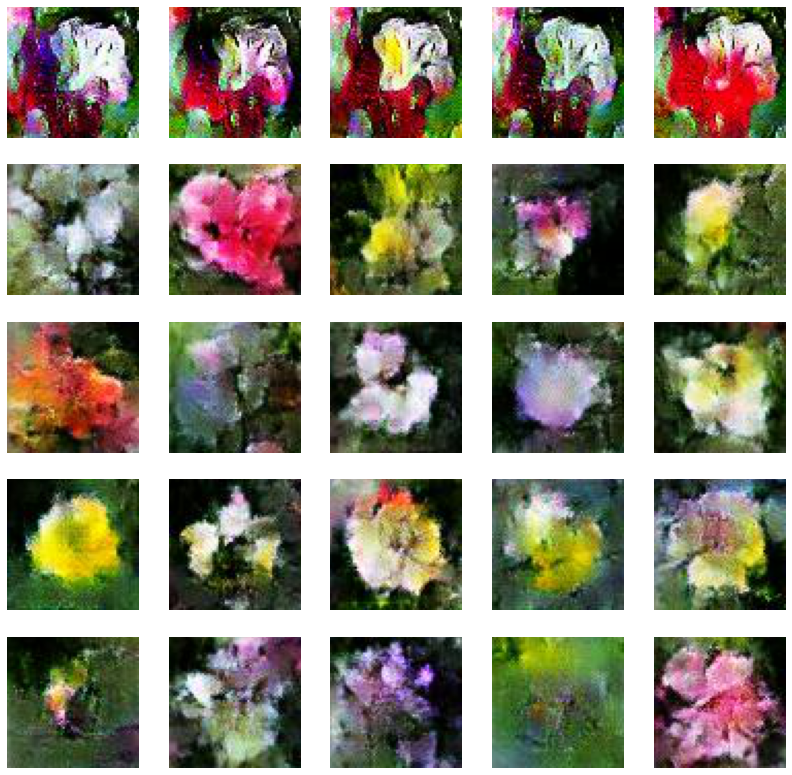

In [60]:
import pandas as pd
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
random_idx = [912, 1238, 1435, 2309, 3565]

visualize(random_idx)